# Tempo para desenvolvimento de projetos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(18, 12)})

In [2]:
dados = pd.read_csv('https://gist.githubusercontent.com/guilhermesilveira/1b7d5475863c15f484ac495bd70975cf/raw/16aff7a0aee67e7c100a2a48b676a2d2d142f646/projects.csv')
dados.head(2)

,unfinished,expected_hours,price
0,1,26,192
1,1,88,9015


In [3]:
a_renomear = {
    'expected_hours' : 'horas_esperadas',
    'price' : 'preco',
    'unfinished' : 'nao_finalizado'
}
dados = dados.rename(columns = a_renomear)
dados.head(2)

,nao_finalizado,horas_esperadas,preco
0,1,26,192
1,1,88,9015


Abaixo vamos corrigir a coluna de "não finalizado", pois a leitura em negativas é menos intuitiva

In [4]:
troca = {
    0 : 1,
    1 : 0
}
dados['finalizado'] = dados.nao_finalizado.map(troca)
del dados['nao_finalizado']
dados.head(2)

,horas_esperadas,preco,finalizado
0,26,192,0
1,88,9015,0


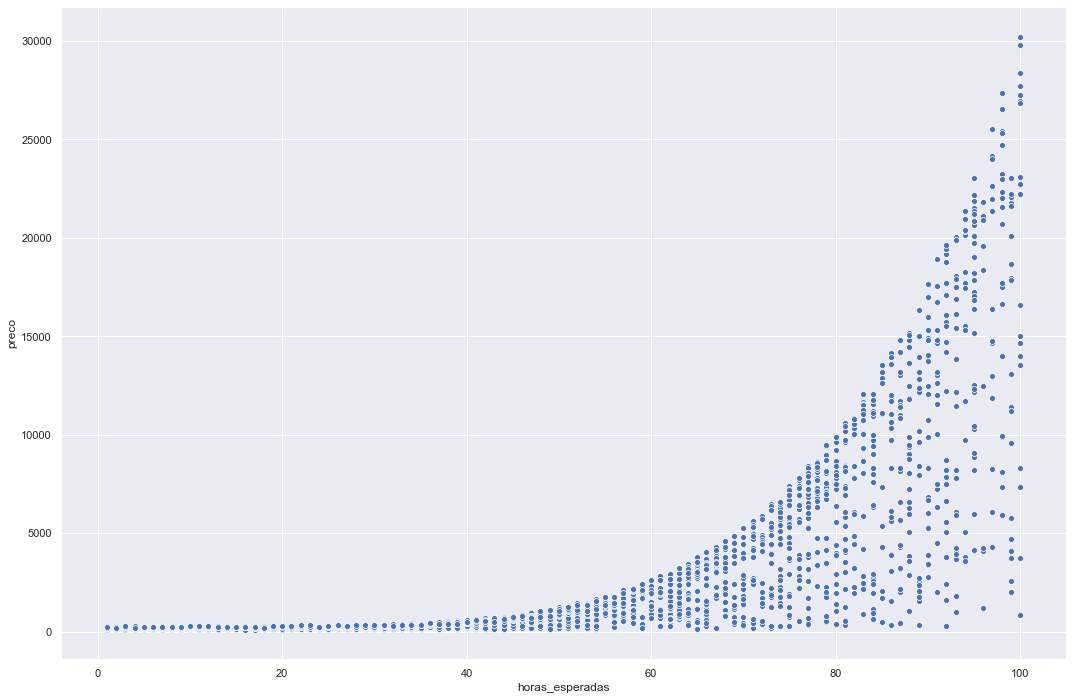

In [5]:
sns.scatterplot(x="horas_esperadas", y="preco", data=dados);

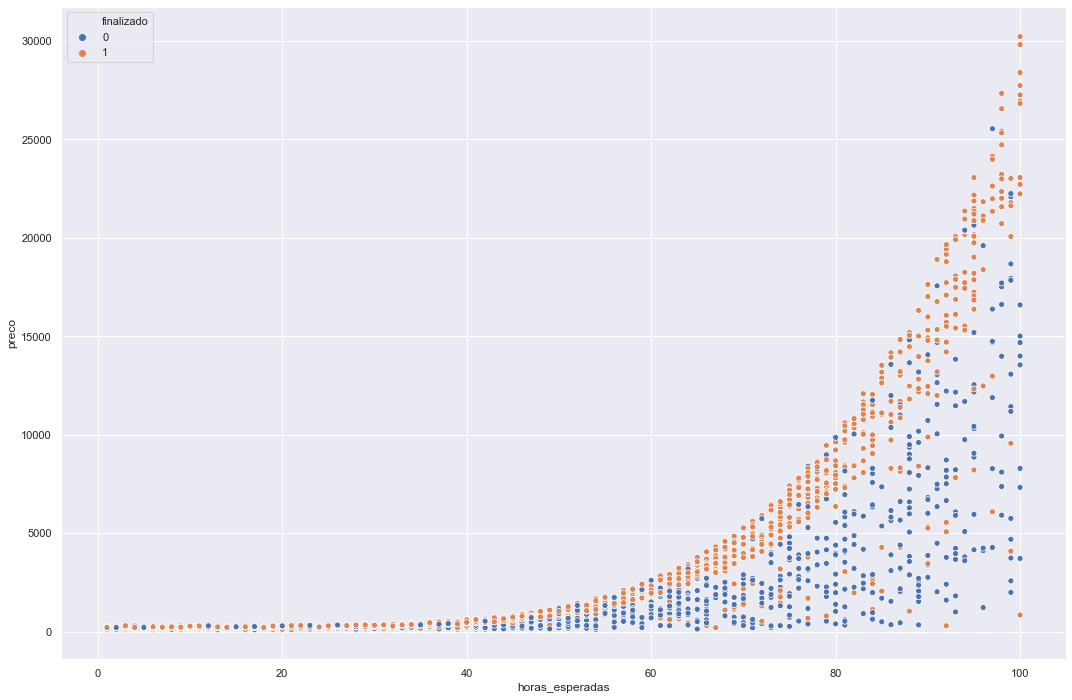

In [6]:
sns.scatterplot(x="horas_esperadas", y="preco", hue="finalizado", data=dados);

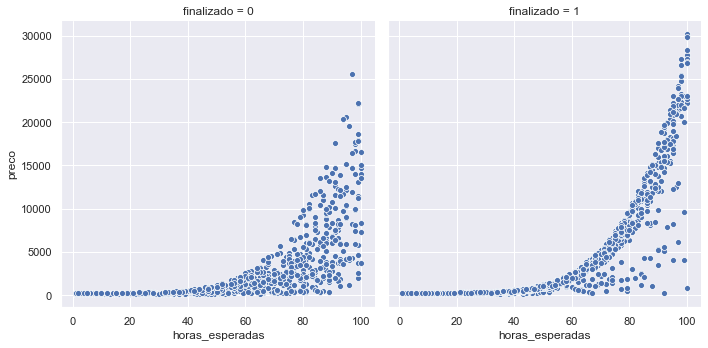

In [7]:
sns.relplot(x="horas_esperadas", y="preco", col="finalizado", data=dados);

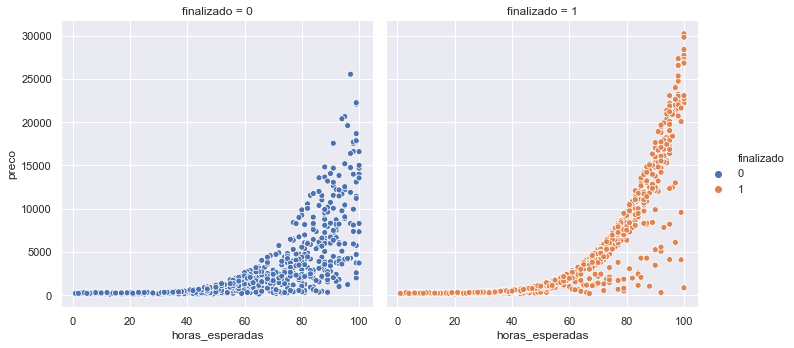

In [8]:
sns.relplot(x="horas_esperadas", y="preco", hue="finalizado", col="finalizado", data=dados);

In [9]:
x = dados[['horas_esperadas', 'preco']]
y = dados['finalizado']

In [10]:
# Vale para o random_state tanto do train_test_split quanto para o LinearSVC
np.random.seed(5)

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

modelo = LinearSVC(dual=False)
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 1617 elementos e testaremos com 540 elementos
A acurácia foi 55.93%


Criando um chute para verificar a qualidade da acurácia (comparando):

In [11]:
linha_base = np.ones(540)
acuracia = accuracy_score(teste_y, linha_base) * 100
print("A acurácia da linha de base foi %.2f%%" % acuracia)

A acurácia da linha de base foi 52.59%


A acurácia da linha de base ("chutar" que todos os valores são 1, ou seja, finalizados) é muito próxima da acurácia do aprendizado, mostrando que o algoritmo não está aprendendo corretamente ou que os dados não são suficientes para tal.

Visualizando o gráfico dos valores de teste:

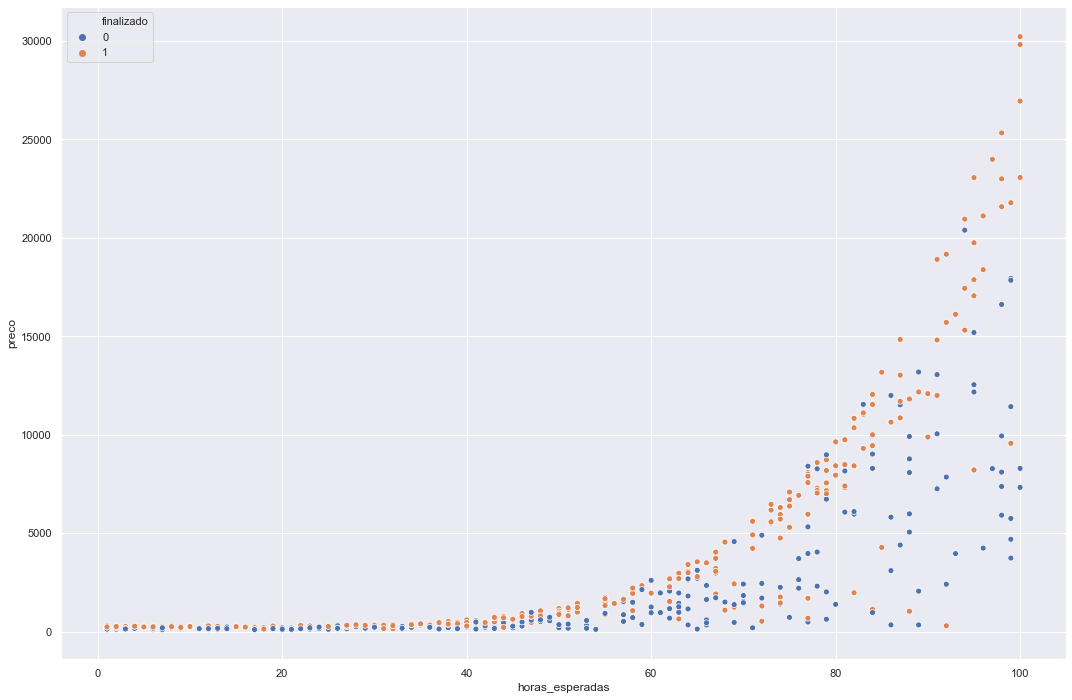

In [12]:
sns.scatterplot(x="horas_esperadas", y="preco", hue=teste_y, data=teste_x);

## Análise gráfica do problema da classificação anterior

In [13]:
# Obtendo valores máximos e mínimos
x_min = teste_x.horas_esperadas.min()
x_max = teste_x.horas_esperadas.max()
y_min = teste_x.preco.min()
y_max = teste_x.preco.max()

In [14]:
# Criação da distribuição dos espaços
pixels = 100
eixo_x = np.arange(x_min, x_max, (x_max - x_min)/ pixels)
eixo_y = np.arange(y_min, y_max, (y_max - y_min)/ pixels)

In [15]:
# Juntando os pontos num grid
xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]

In [16]:
# Predizendo cada local
Z = modelo.predict(pontos)
Z = Z.reshape(xx.shape)

# Note que o shape é (100 x 100), dimensão escolhida
Z.shape

(100, 100)

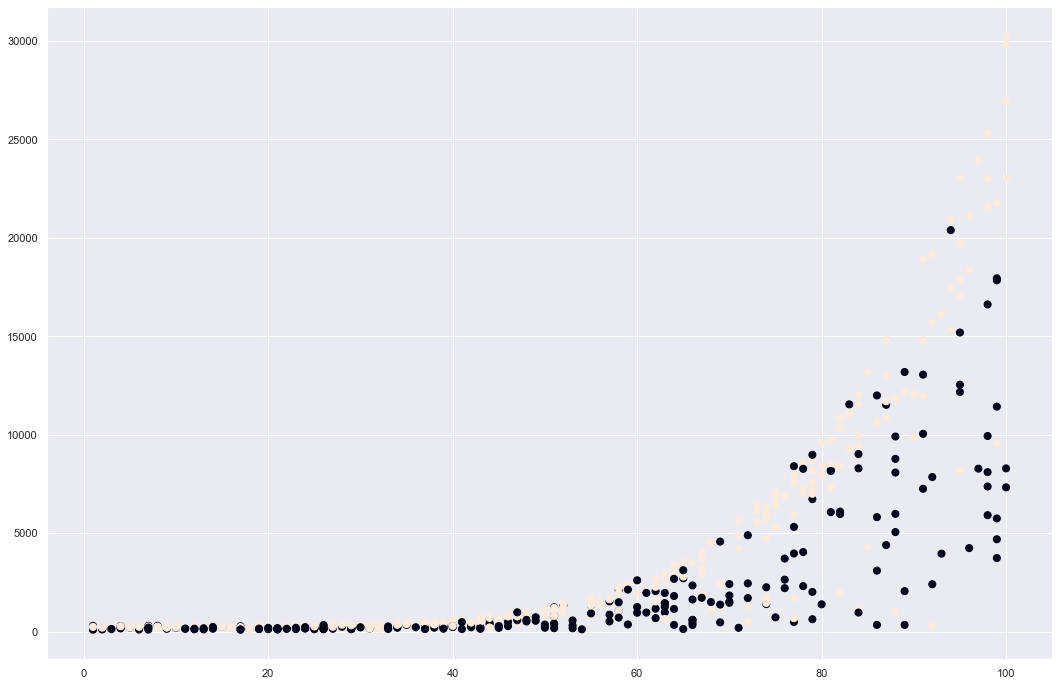

In [17]:
plt.scatter(teste_x.horas_esperadas, teste_x.preco, c=teste_y, s=50);

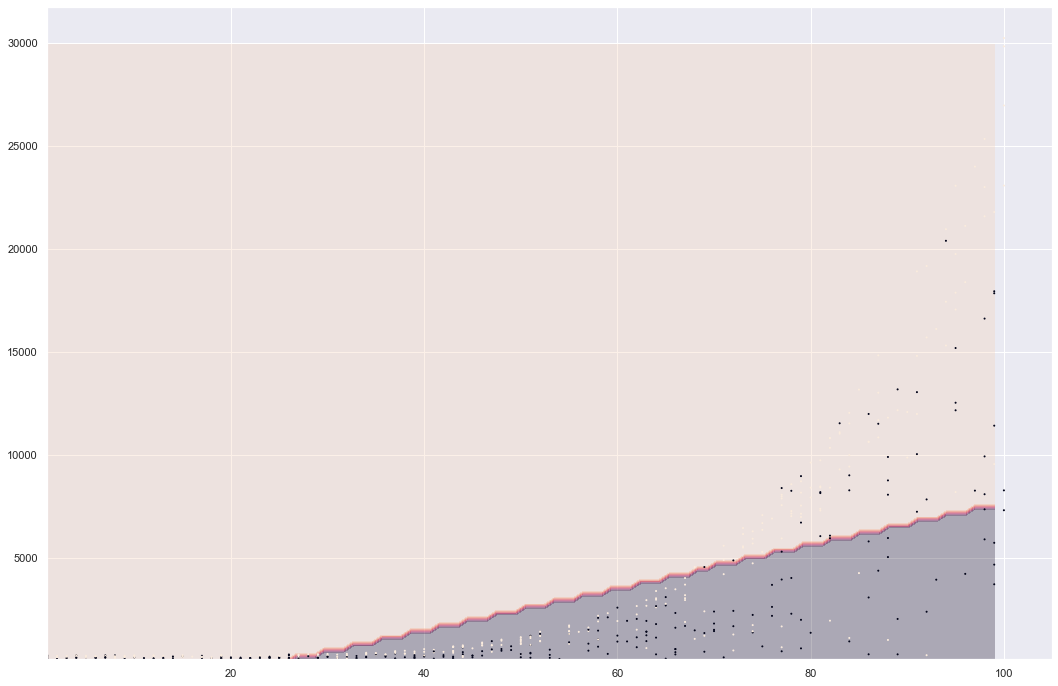

In [18]:
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(teste_x.horas_esperadas, teste_x.preco, c=teste_y, s=1);

Isso tudo demonstra que a linha reta não é suficiente para esta classificação. Ou seja, esse problema **não pode ser resolvido por uma regressão linear**.

## Utilizando o `SVC` ao invés do `LinearSVC`

In [19]:
modelo = SVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

A acurácia foi 55.19%


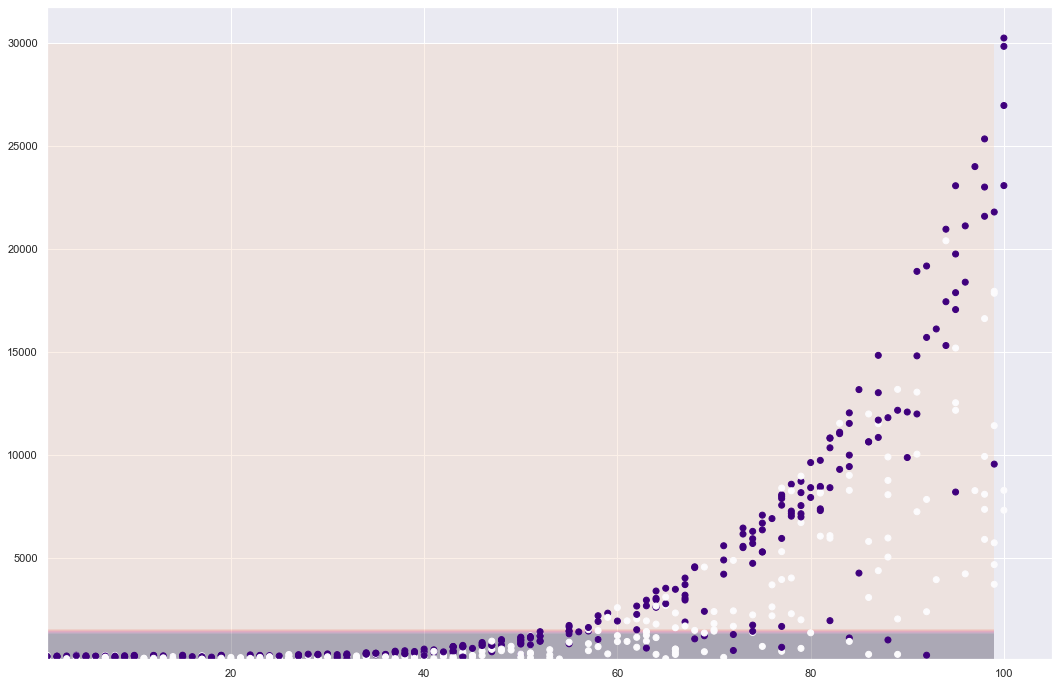

In [20]:
x_min = teste_x.horas_esperadas.min()
x_max = teste_x.horas_esperadas.max()
y_min = teste_x.preco.min()
y_max = teste_x.preco.max()

pixels = 100
eixo_x = np.arange(x_min, x_max, (x_max - x_min) / pixels)
eixo_y = np.arange(y_min, y_max, (y_max - y_min) / pixels)

xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]

Z = modelo.predict(pontos)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(teste_x.horas_esperadas, teste_x.preco, c=teste_y, cmap='Purples')


## Standard Scaler

In [21]:
SEED = 5
np.random.seed(SEED)
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

scaler = StandardScaler()
scaler.fit(raw_treino_x)
treino_x = scaler.transform(raw_treino_x)
teste_x = scaler.transform(raw_teste_x)

modelo = SVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 1617 elementos e testaremos com 540 elementos
A acurácia foi 66.85%


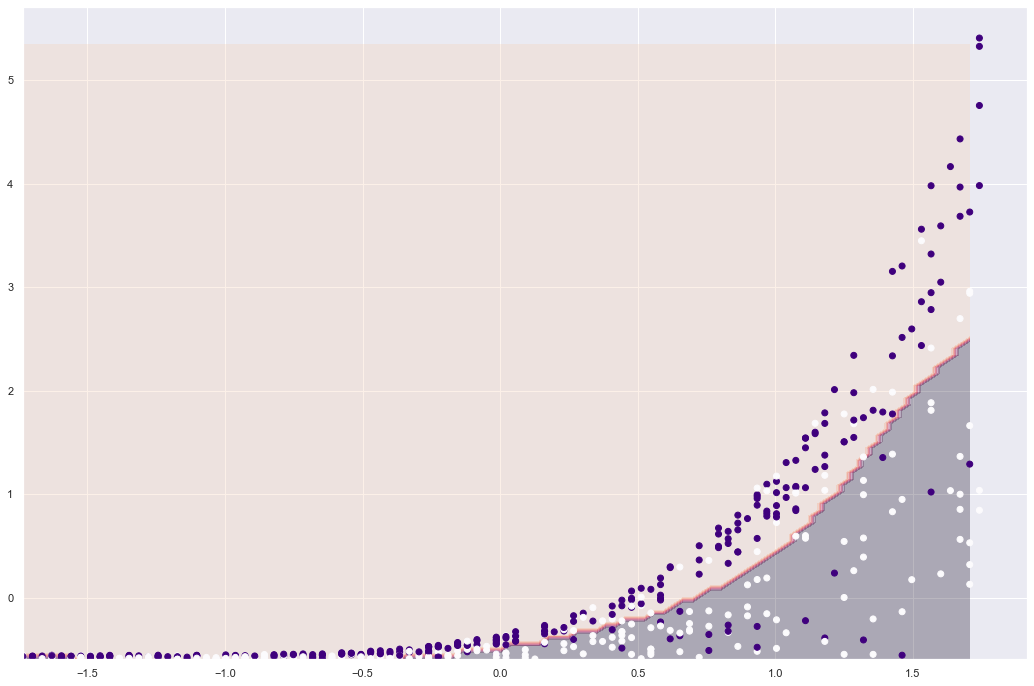

In [22]:
data_x = teste_x[:,0]
data_y = teste_x[:,1]

x_min = data_x.min()
x_max = data_x.max()
y_min = data_y.min()
y_max = data_y.max()

pixels = 100
eixo_x = np.arange(x_min, x_max, (x_max - x_min) / pixels)
eixo_y = np.arange(y_min, y_max, (y_max - y_min) / pixels)

xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]

Z = modelo.predict(pontos)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(data_x, data_y, c=teste_y, cmap='Purples');